# Analiza "Polish companies bankruptcy"


In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.io import arff
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Wczytanie zbioru danych

In [2]:
directory_path = "../dbs/polish+companies+bankruptcy+data/"

dfs = []
for i in range(1, 6):
    file_path = f"{directory_path}{i}year.arff"
    raw_data = arff.loadarff(file_path)
    tmpdf = pd.DataFrame(raw_data[0])
    dfs.append(tmpdf)

df = pd.concat(dfs, ignore_index=True)

print(df.shape)
df.head()

(43405, 65)


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,b'0'
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,b'0'
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,b'0'
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,b'0'
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,b'0'


In [3]:
attribute_count = df.shape[1] - 1
attribute_names = df.columns[:-1].tolist()
attribute_count, attribute_names

(64,
 ['Attr1',
  'Attr2',
  'Attr3',
  'Attr4',
  'Attr5',
  'Attr6',
  'Attr7',
  'Attr8',
  'Attr9',
  'Attr10',
  'Attr11',
  'Attr12',
  'Attr13',
  'Attr14',
  'Attr15',
  'Attr16',
  'Attr17',
  'Attr18',
  'Attr19',
  'Attr20',
  'Attr21',
  'Attr22',
  'Attr23',
  'Attr24',
  'Attr25',
  'Attr26',
  'Attr27',
  'Attr28',
  'Attr29',
  'Attr30',
  'Attr31',
  'Attr32',
  'Attr33',
  'Attr34',
  'Attr35',
  'Attr36',
  'Attr37',
  'Attr38',
  'Attr39',
  'Attr40',
  'Attr41',
  'Attr42',
  'Attr43',
  'Attr44',
  'Attr45',
  'Attr46',
  'Attr47',
  'Attr48',
  'Attr49',
  'Attr50',
  'Attr51',
  'Attr52',
  'Attr53',
  'Attr54',
  'Attr55',
  'Attr56',
  'Attr57',
  'Attr58',
  'Attr59',
  'Attr60',
  'Attr61',
  'Attr62',
  'Attr63',
  'Attr64'])

### Mapowanie nazw atrybutów na ich znaczenie

In [4]:
attribute_mapping = {
    'Attr1':  'net profit / total assets',
    'Attr2':  'total liabilities / total assets',
    'Attr3':  'working capital / total assets',
    'Attr4':  'current assets / short-term liabilities',
    'Attr5':  '((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365',
    'Attr6':  'retained earnings / total assets',
    'Attr7':  'EBIT / total assets',
    'Attr8':  'book value of equity / total liabilities',
    'Attr9':  'sales / total assets',
    'Attr10': 'equity / total assets',
    'Attr11': '(gross profit + extraordinary items + financial expenses) / total assets',
    'Attr12': 'gross profit / short-term liabilities',
    'Attr13': '(gross profit + depreciation) / sales',
    'Attr14': '(gross profit + interest) / total assets',
    'Attr15': '(total liabilities * 365) / (gross profit + depreciation)',
    'Attr16': '(gross profit + depreciation) / total liabilities',
    'Attr17': 'total assets / total liabilities',
    'Attr18': 'gross profit / total assets',
    'Attr19': 'gross profit / sales',
    'Attr20': '(inventory * 365) / sales',
    'Attr21': 'sales (n) / sales (n-1)',
    'Attr22': 'profit on operating activities / total assets',
    'Attr23': 'net profit / sales',
    'Attr24': 'gross profit (in 3 years) / total assets',
    'Attr25': '(equity - share capital) / total assets',
    'Attr26': '(net profit + depreciation) / total liabilities',
    'Attr27': 'profit on operating activities / financial expenses',
    'Attr28': 'working capital / fixed assets',
    'Attr29': 'logarithm of total assets',
    'Attr30': '(total liabilities - cash) / sales',
    'Attr31': '(gross profit + interest) / sales',
    'Attr32': '(current liabilities * 365) / cost of products sold',
    'Attr33': 'operating expenses / short-term liabilities',
    'Attr34': 'operating expenses / total liabilities',
    'Attr35': 'profit on sales / total assets',
    'Attr36': 'total sales / total assets',
    'Attr37': '(current assets - inventories) / long-term liabilities',
    'Attr38': 'constant capital / total assets',
    'Attr39': 'profit on sales / sales',
    'Attr40': '(current assets - inventory - receivables) / short-term liabilities',
    'Attr41': 'total liabilities / ((profit on operating activities + depreciation) * (12/365))',
    'Attr42': 'profit on operating activities / sales',
    'Attr43': 'rotation receivables + inventory turnover in days',
    'Attr44': '(receivables * 365) / sales',
    'Attr45': 'net profit / inventory',
    'Attr46': '(current assets - inventory) / short-term liabilities',
    'Attr47': '(inventory * 365) / cost of products sold',
    'Attr48': 'EBITDA (profit on operating activities - depreciation) / total assets',
    'Attr49': 'EBITDA (profit on operating activities - depreciation) / sales',
    'Attr50': 'current assets / total liabilities',
    'Attr51': 'short-term liabilities / total assets',
    'Attr52': '(short-term liabilities * 365) / cost of products sold',
    'Attr53': 'equity / fixed assets',
    'Attr54': 'constant capital / fixed assets',
    'Attr55': 'working capital',
    'Attr56': '(sales - cost of products sold) / sales',
    'Attr57': '(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)',
    'Attr58': 'total costs /total sales',
    'Attr59': 'long-term liabilities / equity',
    'Attr60': 'sales / inventory',
    'Attr61': 'sales / receivables',
    'Attr62': '(short-term liabilities *365) / sales',
    'Attr63': 'sales / short-term liabilities',
    'Attr64': 'sales / fixed assets'
}
df.columns = [attribute_mapping.get(col, col) for col in df.columns]

In [5]:
# export df to csv
df.to_csv('polish_companies_bankruptcy.csv', index=False)
df

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets,class
0,0.200550,0.37951,0.396410,2.04720,32.3510,0.38825,0.249760,1.33050,1.13890,0.504940,...,0.121960,0.397180,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.42770,b'0'
1,0.209120,0.49988,0.472250,1.94470,14.7860,0.00000,0.258340,0.99601,1.69960,0.497880,...,0.121300,0.420020,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.98700,b'0'
2,0.248660,0.69592,0.267130,1.55480,-1.1523,0.00000,0.309060,0.43695,1.30900,0.304080,...,0.241140,0.817740,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.20780,b'0'
3,0.081483,0.30734,0.458790,2.49280,51.9520,0.14988,0.092704,1.86610,1.05710,0.573530,...,0.054015,0.142070,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.54970,b'0'
4,0.187320,0.61323,0.229600,1.40630,-7.3128,0.18732,0.187320,0.63070,1.15590,0.386770,...,0.134850,0.484310,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.89800,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43400,0.012898,0.70621,0.038857,1.17220,-18.9070,0.00000,0.013981,0.41600,1.67680,0.293790,...,0.020169,0.043904,1.01220,1.259400,13.4720,12.4320,49.117,7.4313,2.27990,b'1'
43401,-0.578050,0.96702,-0.800850,0.16576,-67.3650,-0.57805,-0.578050,-0.40334,0.93979,-0.390040,...,-0.064073,1.482000,1.06410,-0.018084,110.7200,44.7590,81.220,4.4940,5.13050,b'1'
43402,-0.179050,1.25530,-0.275990,0.74554,-120.4400,-0.17905,-0.154930,-0.26018,1.17490,-0.326590,...,0.148880,0.548240,0.85112,-0.522430,9.8526,3.4892,207.870,1.7559,9.95270,b'1'
43403,-0.108860,0.74394,0.015449,1.08780,-17.0030,-0.10886,-0.109180,0.12531,0.84516,0.093224,...,-0.183200,-1.167700,1.18320,6.092400,13.8860,6.0769,83.122,4.3911,0.95575,b'1'


# Analiza zbioru danych
## Sprawdzenie brakujących wartości 

In [6]:
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data

(current assets - inventories) / long-term liabilities                                           18984
sales (n) / sales (n-1)                                                                           5854
profit on operating activities / financial expenses                                               2764
sales / inventory                                                                                 2152
net profit / inventory                                                                            2147
                                                                                                 ...  
equity / total assets                                                                                8
(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)        7
long-term liabilities / equity                                                                       7
working capital                                                          

class
b'0'    41314
b'1'     2091
Name: count, dtype: int64


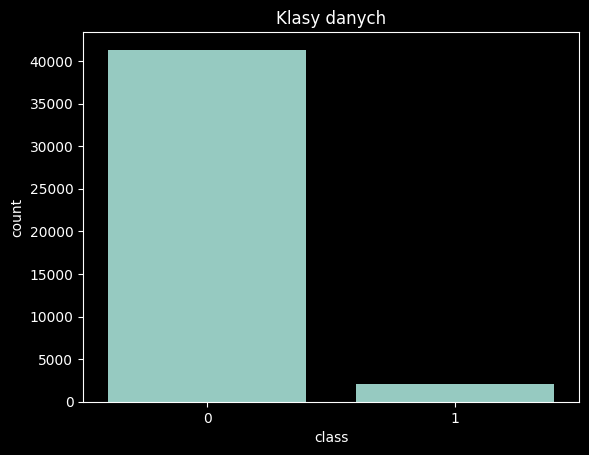

In [7]:
print(df['class'].value_counts())

sns.countplot(x='class', data=df)
plt.title('Klasy danych')
plt.show()

## Zastąpienie kolumny, w której brakuje ponad połowy danych wartościami 0 i 1

In [8]:
df['(current assets - inventories) / long-term liabilities'] = np.where(df['(current assets - inventories) / long-term liabilities'].isnull(), 0, 1)
missing_data = df.isnull().sum().sort_values(ascending=False)
print(missing_data)

sales (n) / sales (n-1)                                                                          5854
profit on operating activities / financial expenses                                              2764
sales / inventory                                                                                2152
net profit / inventory                                                                           2147
gross profit (in 3 years) / total assets                                                          922
                                                                                                 ... 
(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)       7
long-term liabilities / equity                                                                      7
working capital                                                                                     1
(current assets - inventories) / long-term liabilities                            

## Wypełnienie brakujących danych KNNImputerem

In [9]:

if 'class' in df.columns:
    X = df.drop(columns=['class'])
    y = df['class']
else:
    X = df
    y = None

# Utworzenie i zastosowanie KNN imputera
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X_imputed = imputer.fit_transform(X)

# Przywrócenie DataFrame
df_imputed = pd.DataFrame(X_imputed, columns=X.columns)
if y is not None:
    df_imputed['class'] = y.values

# Wyświetlenie informacji o nowym zbiorze danych
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43405 entries, 0 to 43404
Data columns (total 65 columns):
 #   Column                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                               --------------  -----  
 0   net profit / total assets                                                                                            43405 non-null  float64
 1   total liabilities / total assets                                                                                     43405 non-null  float64
 2   working capital / total assets                                                                                       43405 non-null  float64
 3   current assets / short-term liabilities                                                                              43405 non-null  float64
 4   ((cash + s

In [10]:
df = df_imputed
missing_data = df.isnull().sum().sort_values(ascending=False)
missing_data, df.shape

(net profit / total assets                                 0
 operating expenses / total liabilities                    0
 total sales / total assets                                0
 (current assets - inventories) / long-term liabilities    0
 constant capital / total assets                           0
                                                          ..
 working capital / fixed assets                            0
 logarithm of total assets                                 0
 (total liabilities - cash) / sales                        0
 (gross profit + interest) / sales                         0
 class                                                     0
 Length: 65, dtype: int64,
 (43405, 65))

## Sprawdzenie wartości ujemnych w zbiorze danych

In [11]:
# Wybierz tylko kolumny numeryczne z DataFrame
df_numeric = df.select_dtypes(include=[np.number])

# Sprawdzenie, które wartości są ujemne (True dla wartości ujemnych) tylko w kolumnach numerycznych
negative_values_mask = df_numeric.lt(0)

# Zliczenie wartości ujemnych w każdej kolumnie numerycznej
negative_values_count = negative_values_mask.sum().sort_values(ascending=False)

file_path = 'negative_values_count.txt'
with open(file_path, 'w') as file:
    file.write(negative_values_count.to_string())

# Wyświetlenie liczby wartości ujemnych dla każdej kolumny numerycznej
negative_values_count

((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365    21956
EBITDA (profit on operating activities - depreciation) / total assets                                                  17805
EBITDA (profit on operating activities - depreciation) / sales                                                         17766
retained earnings / total assets                                                                                        9723
working capital / total assets                                                                                          9569
                                                                                                                       ...  
(inventory * 365) / sales                                                                                                  2
current assets / short-term liabilities                                                                                    2


## Zapisanie wartości które mogą być ujemne i korekcja tych, które nie mogą

In [12]:
columns_should_not_be_negative = [
    'working capital',
    'working capital / total assets',
    'working capital / fixed assets',
    'gross profit / sales',
    '(sales - cost of products sold) / sales',
    'gross profit / short-term liabilities',
    'gross profit / total assets',
    'gross profit (in 3 years) / total assets',
    '(gross profit + extraordinary items + financial expenses) / total assets',
    '(gross profit + interest) / total assets',
    '(gross profit + depreciation) / total liabilities',
    '(gross profit + depreciation) / sales',
    'equity / total assets',
    'equity / fixed assets',
    'constant capital / total assets',
    'constant capital / fixed assets',
    'book value of equity / total liabilities',
    'sales / total assets',
    'sales / fixed assets',
    'total assets / total liabilities',
    'current assets / total liabilities',
    'current assets / short-term liabilities',
    'sales / inventory',
    'sales / receivables',
    '(current assets - inventory - receivables) / short-term liabilities',
    '(current assets - inventory) / short-term liabilities',
    '(current assets - inventories) / long-term liabilities'
]

# Sprawdzenie, które wartości w tych kolumnach są ujemne
for column in columns_should_not_be_negative:
    if column in df.columns:

        # Obliczenie średniej z dodatnich wartości
        positive_mean = df[df[column] > 0][column].mean()
        
        # Zastąpienie wartości ujemnych średnią
        df.loc[df[column] < 0, column] = positive_mean


### Ponowne sprawdzenie ujemnych wartości

In [13]:
# Wybierz tylko kolumny numeryczne z DataFrame
df_numeric = df.select_dtypes(include=[np.number])

# Sprawdzenie, które wartości są ujemne (True dla wartości ujemnych) tylko w kolumnach numerycznych
negative_values_mask = df_numeric.lt(0)

# Zliczenie wartości ujemnych w każdej kolumnie numerycznej
negative_values_count = negative_values_mask.sum().sort_values(ascending=False)

file_path = 'negative_values_count_after_correction.txt'
with open(file_path, 'w') as file:
    file.write(negative_values_count.to_string())

negative_values_count

((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365    21956
EBITDA (profit on operating activities - depreciation) / total assets                                                  17805
EBITDA (profit on operating activities - depreciation) / sales                                                         17766
retained earnings / total assets                                                                                        9723
net profit / inventory                                                                                                  9304
                                                                                                                       ...  
constant capital / total assets                                                                                            0
(current assets - inventories) / long-term liabilities                                                                     0


## Zapis do pliku po analizie zbioru danych

In [14]:
df.to_csv('processed_polish_companies_bankruptcy.csv', index=False)

## Normalizacja i standaryzacja danych

### Normalizacja

In [15]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

df_normalized = pd.DataFrame(X_scaled, columns=X.columns)
df_normalized['class'] = df_imputed['class'].values

df_normalized.describe().round(2)

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets
count,43397.00,43397.00,43397.00,43271.00,43316.0,43397.00,43397.00,43311.00,43396.00,43397.00,...,43404.00,43278.0,43398.00,43321.0,43398.00,41253.00,43303.00,43278.00,43271.00,42593.00
mean,0.83,0.47,0.94,0.00,0.9,0.48,0.44,0.00,0.00,0.30,...,0.23,1.0,0.75,0.0,0.01,0.00,0.00,0.09,0.00,0.04
std,0.01,0.01,0.01,0.01,0.0,0.01,0.00,0.01,0.01,0.01,...,0.01,0.0,0.01,0.0,0.01,0.01,0.01,0.01,0.01,0.01
min,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.83,0.47,0.94,0.00,0.9,0.48,0.44,0.00,0.00,0.30,...,0.23,1.0,0.75,0.0,0.01,0.00,0.00,0.09,0.00,0.03
50%,0.83,0.47,0.94,0.00,0.9,0.48,0.44,0.00,0.00,0.30,...,0.23,1.0,0.75,0.0,0.01,0.00,0.00,0.09,0.00,0.03
75%,0.83,0.47,0.95,0.00,0.9,0.48,0.44,0.00,0.00,0.30,...,0.23,1.0,0.75,0.0,0.01,0.00,0.00,0.09,0.00,0.03
max,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00,...,1.00,1.0,1.00,1.0,1.00,1.00,1.00,1.00,1.00,1.00


### Standaryzacja danych

In [16]:
scaler = StandardScaler()

X_standardized = scaler.fit_transform(X)

df_standardized = pd.DataFrame(X_standardized, columns=X.columns)
df_standardized['class'] = df_imputed['class'].values

df_standardized.describe().round(2)

,net profit / total assets,total liabilities / total assets,working capital / total assets,current assets / short-term liabilities,((cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)) * 365,retained earnings / total assets,EBIT / total assets,book value of equity / total liabilities,sales / total assets,equity / total assets,...,working capital,(sales - cost of products sold) / sales,(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation),total costs /total sales,long-term liabilities / equity,sales / inventory,sales / receivables,(short-term liabilities *365) / sales,sales / short-term liabilities,sales / fixed assets
count,43397.00,43397.00,43397.00,43271.00,43316.00,43397.00,43397.00,43311.00,43396.00,43397.00,...,43404.00,43278.00,43398.00,43321.00,43398.00,41253.00,43303.00,43278.00,43271.00,42593.00
mean,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,...,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-154.95,-73.85,-88.26,-0.02,-194.35,-70.59,-90.60,-0.30,-0.10,-32.76,...,-25.88,-208.02,-121.93,-0.04,-2.70,-0.01,-0.05,-16.79,-0.09,-4.54
25%,-0.01,-0.05,-0.02,-0.02,0.01,0.01,-0.02,-0.02,-0.03,-0.02,...,-0.11,0.00,0.00,-0.01,-0.01,-0.01,-0.02,-0.01,-0.05,-0.03
50%,0.00,-0.02,0.02,-0.02,0.01,0.01,-0.01,-0.02,-0.02,-0.01,...,-0.09,0.00,0.01,-0.01,-0.01,-0.01,-0.02,-0.01,-0.03,-0.03
75%,0.03,0.02,0.05,-0.01,0.01,0.02,0.01,-0.02,-0.01,0.01,...,-0.04,0.00,0.02,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.03
max,31.48,82.22,5.19,180.84,20.42,75.45,113.62,105.60,154.76,74.90,...,87.31,0.06,40.42,207.76,195.34,148.96,195.25,179.62,188.80,124.38


### Srandaryzacja vs normalizacja
Normalizacja polega na przeskalowaniu danych w taki sposób, że wartości każdej kolumny mieszczą się w przedziale od 0 do 1.

Standaryzacja polega na przeskalowaniu danych w taki sposób, że średnia wartość każdej kolumny wynosi 0, a odchylenie standardowe 1. 

W sieciach neuronowych normalizacja jest preferowana bo nie zakładamy żadnego rozkładu danych.
Standaryzacja jest lepsza gdy zakładamy rozkład gaussa i gdy jest mało wartości brzegowych.

## Detekcja outlierów dla znormalizowanego zbioru danych

In [17]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.3, random_state=42)

# Trenowanie modelu na znormalizowanych danych (bez kolumny 'class')
outliers = iso_forest.fit_predict(df_normalized.drop(columns=['class', 'outlier'], errors='ignore'))

# Dodanie wyników do DataFrame
df_normalized['outlier'] = outliers

# Wartości -1 oznaczają wykryte wartości odstające, 1 oznacza normalne obserwacje
outliers_detected = df_normalized[df_normalized['outlier'] == -1]

print(f"Liczba wykrytych wartości odstających: {outliers_detected.shape[0]}")
# outliers_detected.head()

# Usunięcie obserwacji zaklasyfikowanych jako wartości odstające (outlier == -1)
df_normalized_cleaned = df_normalized[df_normalized['outlier'] != -1]
df_normalized = df_normalized_cleaned.drop(columns=['outlier'], errors='ignore')
print(f"Liczba obserwacji po usunięciu wartości odstających: {df_normalized.shape[0]}")

ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Detekcja outlierów dla zstandaryzowanego zbioru danych

In [ ]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.3, random_state=42)

# Trenowanie modelu na znormalizowanych danych (bez kolumny 'class')
outliers = iso_forest.fit_predict(df_standardized.drop(columns=['class', 'outlier'], errors='ignore'))

# Dodanie wyników do DataFrame
df_standardized['outlier'] = outliers

# Wartości -1 oznaczają wykryte wartości odstające, 1 oznacza normalne obserwacje
outliers_detected = df_standardized[df_standardized['outlier'] == -1]

print(f"Liczba wykrytych wartości odstających: {outliers_detected.shape[0]}")

# Usunięcie obserwacji zaklasyfikowanych jako wartości odstające (outlier == -1)
df_standardized_cleaned = df_standardized[df_standardized['outlier'] != -1]

# Usunięcie kolumny 'outlier', ponieważ nie będzie już potrzebna
df_standardized = df_standardized_cleaned.drop(columns=['outlier'], errors='ignore')

# Wyświetlenie informacji o zaktualizowanym DataFrame
print(f"Liczba obserwacji po usunięciu wartości odstających: {df_standardized.shape[0]}")



Liczba wykrytych wartości odstających: 13022
Liczba obserwacji po usunięciu wartości odstających: 30383


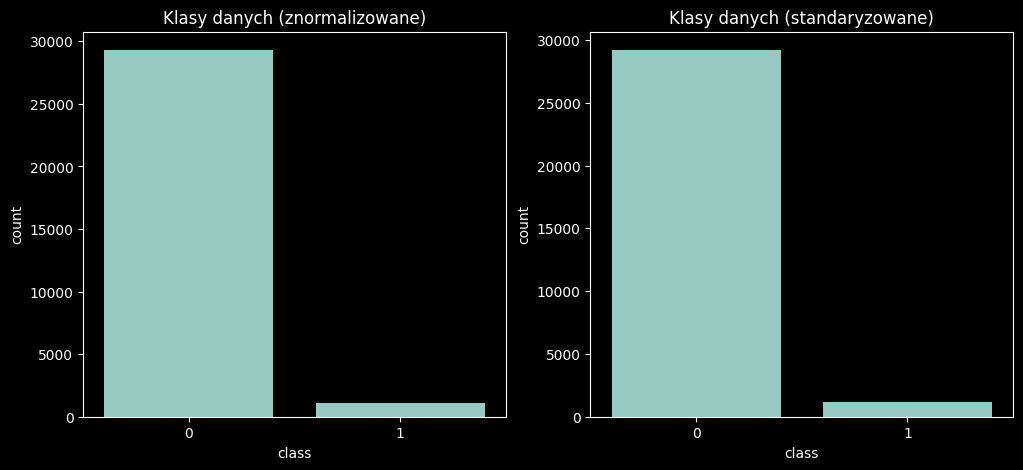

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='class', data=df_normalized)
plt.title('Klasy danych (znormalizowane)')

plt.subplot(1, 2, 2)
sns.countplot(x='class', data=df_standardized)
plt.title('Klasy danych (standaryzowane)')
plt.show()

# Redukcja wymiarowości w zbiorze danych
## PCA na normalized i standardized data

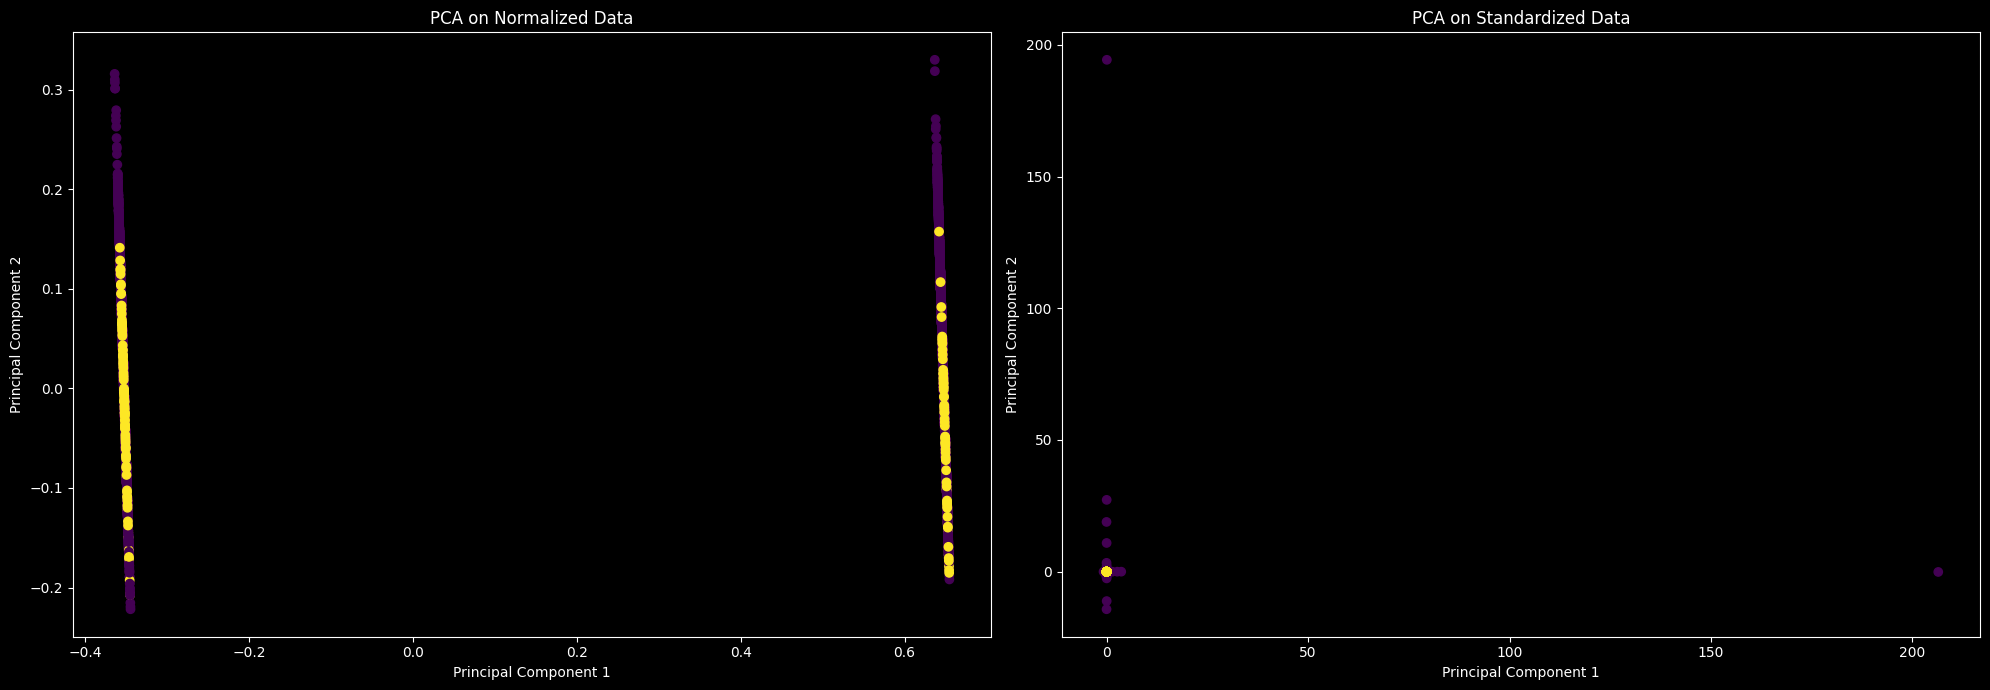

In [ ]:
pca = PCA(n_components=2)
X_pca_normalized = pca.fit_transform(df_normalized.drop(columns=['class', 'outlier'], errors='ignore'))
X_pca_standardized = pca.fit_transform(df_standardized.drop(columns=['class', 'outlier'], errors='ignore'))

fig, axes = plt.subplots(1, 2, figsize=(20, 7))

axes[0].scatter(X_pca_normalized[:, 0], X_pca_normalized[:, 1], c=df_normalized['class'], cmap='viridis')
axes[0].set_xlabel('Principal Component 1')
axes[0].set_ylabel('Principal Component 2')
axes[0].set_title('PCA on Normalized Data')

axes[1].scatter(X_pca_standardized[:, 0], X_pca_standardized[:, 1], c=df_standardized['class'], cmap='viridis')
axes[1].set_xlabel('Principal Component 1')
axes[1].set_ylabel('Principal Component 2')
axes[1].set_title('PCA on Standardized Data')

plt.tight_layout()
plt.show()

## t-SNE eksperyment dla normalized i standardized przy różnych perplexity values

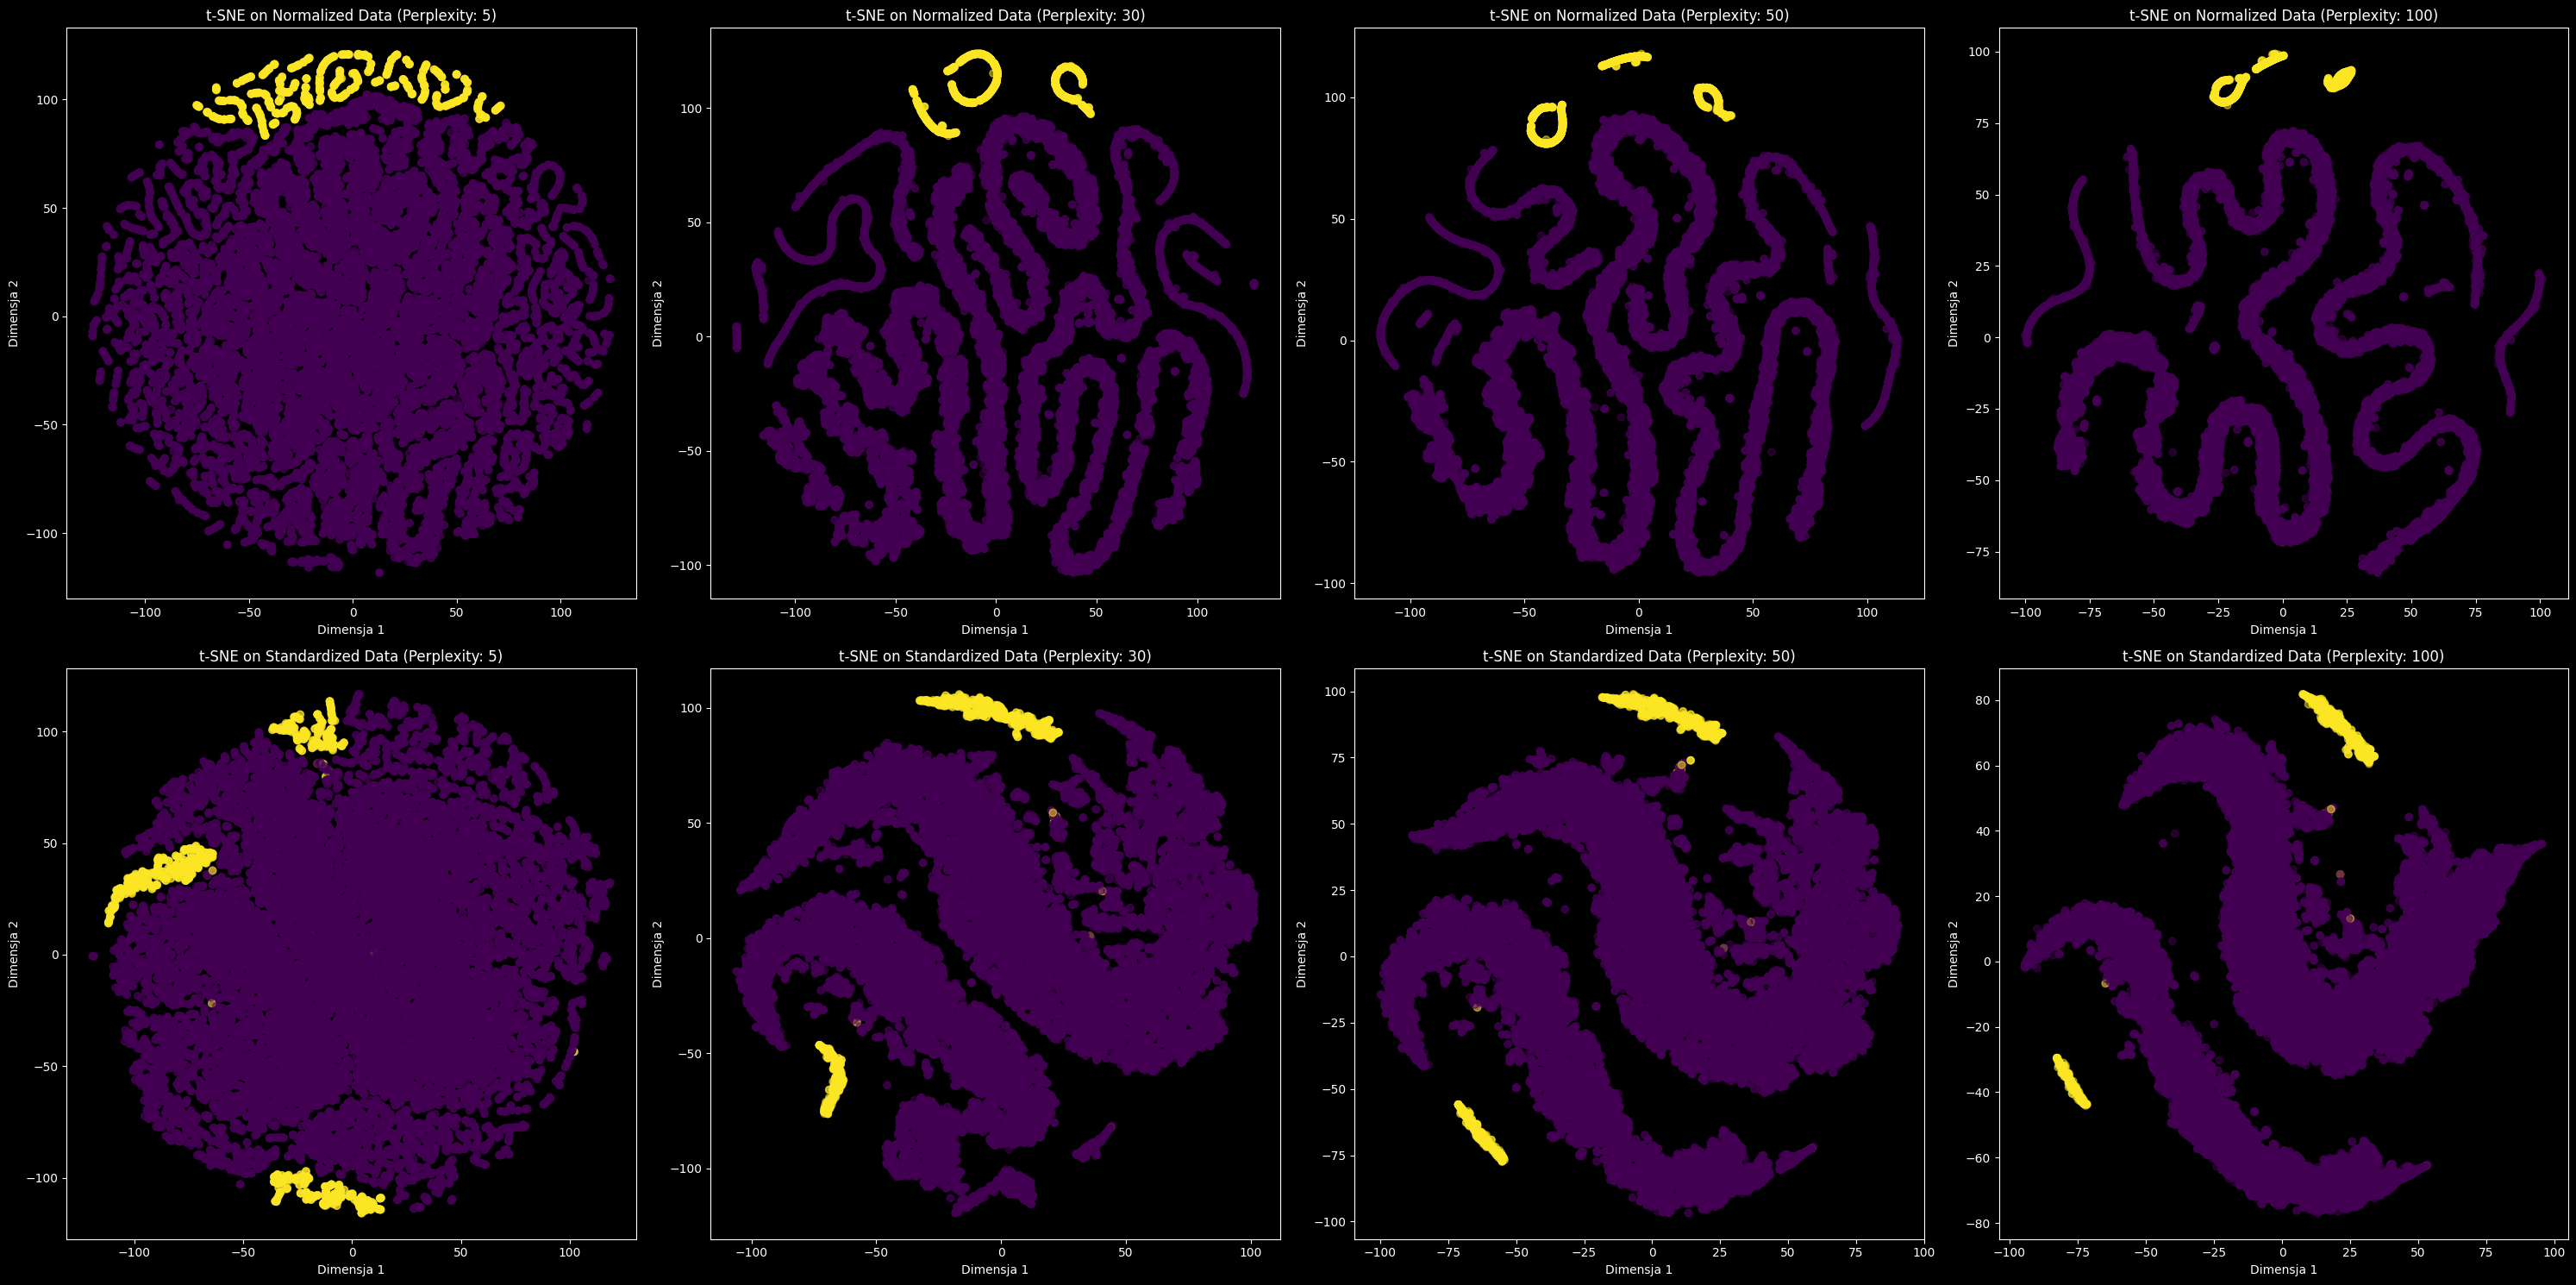

In [ ]:
perplexity_values = [5, 30, 50, 100]

fig, axes = plt.subplots(2, 4, figsize=(30, 15))

for index, perplexity in enumerate(perplexity_values):
    
    # t-SNE dla znormalizowanych danych
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_result_normalized = tsne.fit_transform(df_normalized)
    
    axes[0, index].scatter(tsne_result_normalized[:, 0], tsne_result_normalized[:, 1], c=df_normalized['class'], alpha=0.5, cmap='viridis')
    axes[0, index].set_title(f't-SNE on Normalized Data (Perplexity: {perplexity})')
    axes[0, index].set_xlabel('Dimensja 1')
    axes[0, index].set_ylabel('Dimensja 2')

    # t-SNE dla zstandaryzowanych danych
    tsne_result_standardized = tsne.fit_transform(df_standardized)
    
    axes[1, index].scatter(tsne_result_standardized[:, 0], tsne_result_standardized[:, 1], c=df_standardized['class'], alpha=0.5, cmap='viridis')
    axes[1, index].set_title(f't-SNE on Standardized Data (Perplexity: {perplexity})')
    axes[1, index].set_xlabel('Dimensja 1')
    axes[1, index].set_ylabel('Dimensja 2')

plt.tight_layout()
plt.show()

# Model Random Forest Klasyfikator

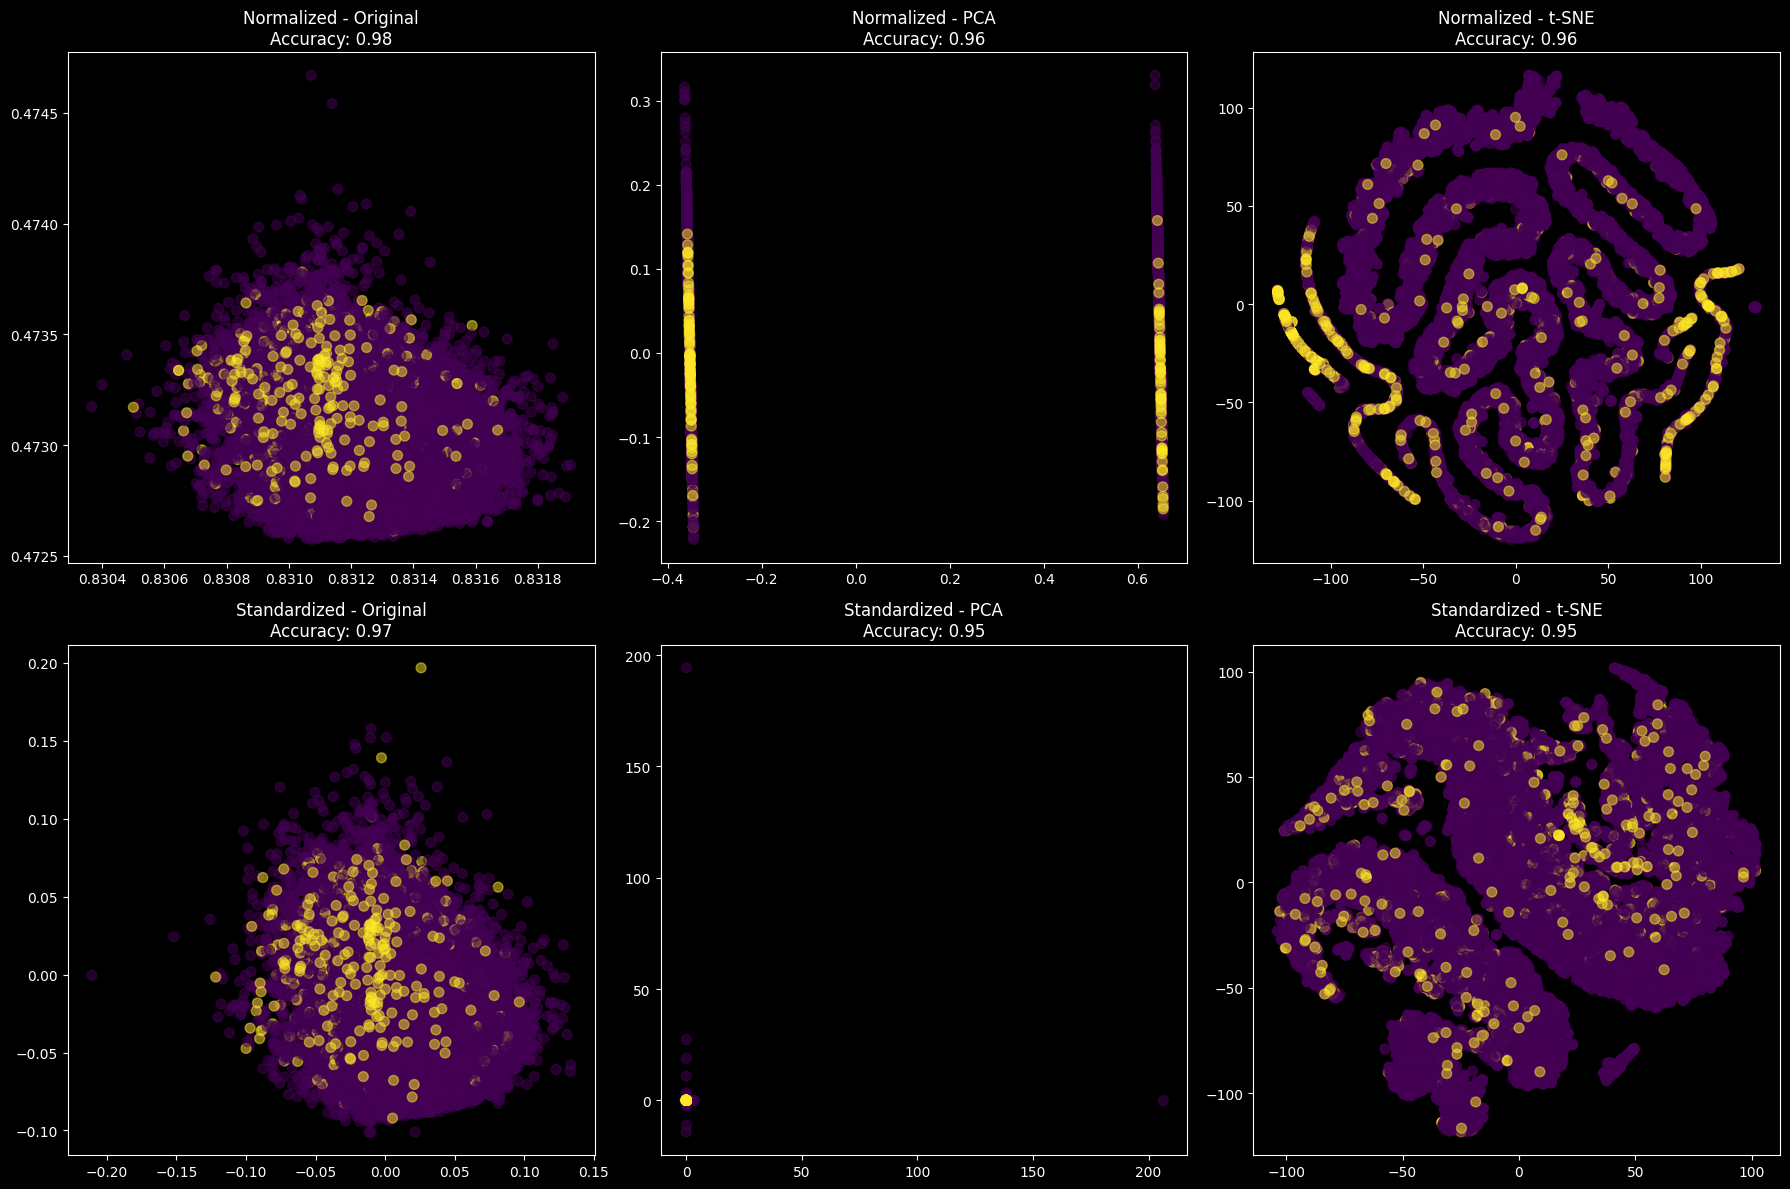

{'Normalized': {'Original': 0.9758104327793319,
  'PCA': 0.9596840546322198,
  't-SNE': 0.9644561461247326},
 'Standardized': {'Original': 0.9740003291097581,
  'PCA': 0.954747408260655,
  't-SNE': 0.9512917558005595}}

In [ ]:
# Przygotowanie danych
df_normalized['class_encoded'] = LabelEncoder().fit_transform(df_normalized['class'])
df_standardized['class_encoded'] = LabelEncoder().fit_transform(df_standardized['class'])

# Definicja funkcji do przetwarzania i wizualizacji
def process_and_visualize(X, y, method_name, ax):
    # Podział na zbiór treningowy i testowy
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Klasyfikacja za pomocą RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Dokładność
    accuracy = accuracy_score(y_test, y_pred)

    # Wizualizacja (dla 2 pierwszych cech, dla uproszczenia)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, alpha=0.5)
    ax.set_title(f"{method_name}\nAccuracy: {accuracy:.2f}")

    return accuracy


# Inicjalizacja PCA i t-SNE
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)

# Słowniki na wyniki
results = {
    "Normalized": {"Original": None, "PCA": None, "t-SNE": None},
    "Standardized": {"Original": None, "PCA": None, "t-SNE": None}
}

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Przetwarzanie i wizualizacja dla danych znormalizowanych i zstandaryzowanych
for i, (df, name) in enumerate([(df_normalized, "Normalized"), (df_standardized, "Standardized")]):
    X = df.drop(columns=['class', 'class_encoded']).values
    y = df['class_encoded'].values

    # Dane oryginalne
    results[name]["Original"] = process_and_visualize(X, y, f"{name} - Original", axes[i, 0])

    # PCA
    X_pca = pca.fit_transform(X)
    results[name]["PCA"] = process_and_visualize(X_pca, y, f"{name} - PCA", axes[i, 1])

    # t-SNE
    X_tsne = tsne.fit_transform(X)
    results[name]["t-SNE"] = process_and_visualize(X_tsne, y, f"{name} - t-SNE", axes[i, 2])

plt.tight_layout()
plt.show()

results

In [ ]:
raw_df = pd.concat(dfs, ignore_index=True)
raw_df = raw_df.fillna(0)

raw_df['class_encoded'] = LabelEncoder().fit_transform(raw_df['class'])

X_raw = raw_df.drop(columns=['class', 'class_encoded']).values
y_raw = raw_df['class_encoded'].values

# Podział na zbiór treningowy i testowy
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

# Klasyfikacja za pomocą RandomForestClassifier
clf_raw = RandomForestClassifier(n_estimators=100, random_state=42)
clf_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = clf_raw.predict(X_test_raw)

accuracy_raw = accuracy_score(y_test_raw, y_pred_raw)

print(f"Accuracy dla surowych danych: {accuracy_raw:.2f}")

Accuracy dla surowych danych: 0.96
